# Stock Trading Signal & Future Price Prediction Using Technical Indicators and Machine Learning

**Objective:**  
Predict Buy/Hold/Sell signals for stocks using technical indicators (MACD, RSI, Bollinger Bands) and machine learning models (Logistic Regression, Random Forest, SVM). Additionally, forecast future stock prices using Random Forest Regression to provide guidance on potential price movements.

**Dataset:**  
Daily stock prices for multiple tickers, including Open, High, Low, Close, and Volume.

**Note:**  
This project is for demonstration purposes only. Signal classification and future price prediction do not account for transaction costs, slippage, or market impact. Results should **not** be used for live trading.


In [ ]:
# Step 1 — Imports and Setup
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

# Directories
INPUT_CSV = "clean_data.csv"
OUTPUT_DIR = "outputs"
MODEL_DIR = "models"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


In [ ]:
# Step 2 — Load Data and Initial Exploration
df = pd.read_csv(INPUT_CSV, parse_dates=["date"])
df = df.reset_index(drop=True)

print("Loaded data shape:", df.shape)
print("Columns:", df.columns.tolist())

# Quick look
df.head()

# Basic statistics
df.describe()

# Check missing values
df.isna().sum()


Loaded data shape: (26703, 51)
Columns: ['ticker', 'open', 'close', 'adj_close', 'low', 'high', 'volume', 'date', 'ma_7', 'ma_30', 'volatility_30', 'daily_return', 'future_close', 'sector_CONSUMER NON-DURABLES', 'sector_CONSUMER SERVICES', 'sector_ENERGY', 'sector_FINANCE', 'sector_HEALTH CARE', 'sector_PUBLIC UTILITIES', 'sector_TECHNOLOGY', 'sector_Unknown', 'industry_COMPUTER MANUFACTURING', 'industry_COMPUTER SOFTWARE: PREPACKAGED SOFTWARE', 'industry_INVESTMENT MANAGERS', 'industry_MAJOR BANKS', 'industry_MEAT/POULTRY/FISH', 'industry_MEDICAL SPECIALITIES', 'industry_OIL & GAS PRODUCTION', 'industry_OTHER CONSUMER SERVICES', 'industry_OTHER SPECIALTY STORES', 'industry_REAL ESTATE', 'industry_SEMICONDUCTORS', 'industry_SPECIALTY CHEMICALS', 'industry_TELECOMMUNICATIONS EQUIPMENT', 'industry_Unknown', 'exchange_NYSE', 'name_8X8 INC', 'name_AMERICAN SOFTWARE, INC.', 'name_APOLLO GLOBAL MANAGEMENT, LLC', 'name_APPLE INC.', 'name_ARMADA HOFFLER PROPERTIES, INC.', 'name_BLACKROCK MUNIH

,0
ticker,0
open,0
close,0
adj_close,0
low,0
high,0
volume,0
date,0
ma_7,0
ma_30,0


**Insights:**  
- Check for missing data or anomalies.
- Verify that `ticker` and `date` columns are correctly parsed.


In [ ]:
# Step 3 — Feature Engineering: Technical Indicators
def compute_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def compute_macd(df, price_col="close"):
    df = df.copy()
    df["MACD"] = df.groupby("ticker")[price_col].transform(lambda s: compute_ema(s, 12) - compute_ema(s, 26))
    df["MACD_signal"] = df.groupby("ticker")["MACD"].transform(lambda s: compute_ema(s, 9))
    return df

def compute_rsi(df, price_col="close", period=14):
    df = df.copy()
    def rsi_series(close):
        delta = close.diff()
        gain = delta.where(delta>0,0)
        loss = -delta.where(delta<0,0)
        avg_gain = gain.ewm(span=period, adjust=False).mean()
        avg_loss = loss.ewm(span=period, adjust=False).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)
    df["RSI"] = df.groupby("ticker")[price_col].transform(rsi_series)
    return df

df = compute_macd(df)
df = compute_rsi(df)

**Explanation:**  
- **MACD:** Measures short-term vs long-term momentum. Buy signal occurs when MACD crosses above the signal line.  
- **RSI:** Measures overbought/oversold conditions. RSI <30 → Buy, RSI >70 → Sell.  


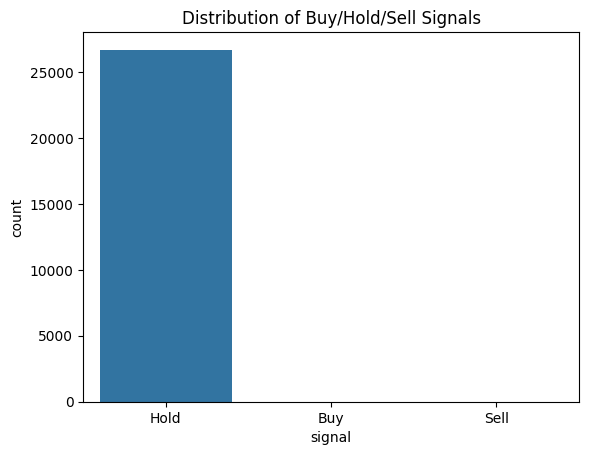

In [ ]:
# Step 4 — Generate Buy/Hold/Sell Signals
def generate_signals(df):
    df = df.copy().sort_values(["ticker", "date"])
    # MACD cross
    df["MACD_prev"] = df.groupby("ticker")["MACD"].shift(1)
    df["MACD_signal_prev"] = df.groupby("ticker")["MACD_signal"].shift(1)

    def macd_flag(row):
        if pd.isna(row["MACD_prev"]) or pd.isna(row["MACD_signal_prev"]):
            return "Neutral"
        if (row["MACD_prev"] < row["MACD_signal_prev"]) and (row["MACD"] > row["MACD_signal"]):
            return "Buy"
        if (row["MACD_prev"] > row["MACD_signal_prev"]) and (row["MACD"] < row["MACD_signal"]):
            return "Sell"
        return "Neutral"

    df["MACD_flag"] = df.apply(macd_flag, axis=1)

    # RSI flag
    df["RSI_flag"] = df["RSI"].apply(lambda r: "Buy" if r<30 else ("Sell" if r>70 else "Neutral"))

    # Combined signal
    df["signal"] = df.apply(lambda row: "Buy" if row["MACD_flag"]=="Buy" and row["RSI_flag"]=="Buy" else
                                       ("Sell" if row["MACD_flag"]=="Sell" and row["RSI_flag"]=="Sell" else "Hold"), axis=1)
    df.drop(columns=["MACD_prev","MACD_signal_prev"], inplace=True)
    return df

df = generate_signals(df)

# Quick check
df[["ticker","date","MACD","MACD_signal","RSI","MACD_flag","RSI_flag","signal"]].head()

# Signal distribution plot
sns.countplot(x="signal", data=df)
plt.title("Distribution of Buy/Hold/Sell Signals")
plt.show()


 Note: Signal labels are derived from technical indicator rules, not future returns.
The ML models learn to approximate rule-based signals rather than directly optimizing profit.

In [ ]:
# Step 5 — Prepare ML Dataset
df["label"] = df["signal"].map({"Hold":0, "Buy":1, "Sell":2})
features = ["MACD","MACD_signal","RSI"]
X = df[features]
y = df["label"]

# Train/Val/Test split (time-series safe)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.17647, shuffle=False)

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)


Train/Val/Test shapes: (18691, 3) (4006, 3) (4006, 3)


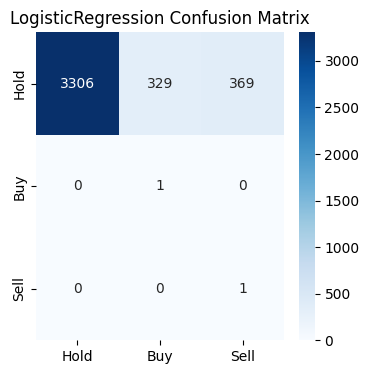

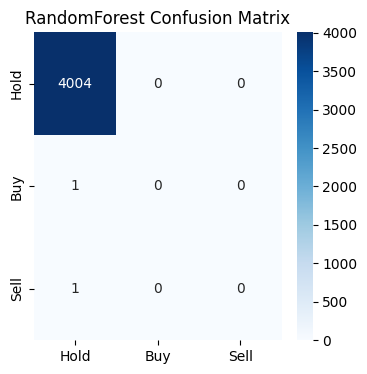

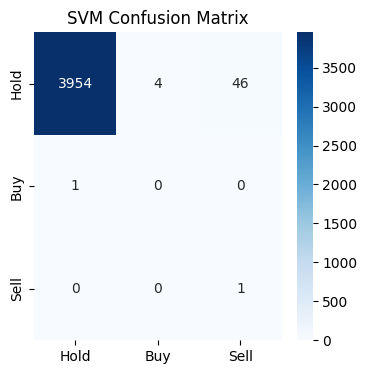

,model,accuracy,precision,recall,f1
0,LogisticRegression,0.825761,0.999502,0.825761,0.904066
1,RandomForest,0.999501,0.999002,0.999501,0.999251
2,SVM,0.987269,0.999253,0.987269,0.993107


In [ ]:
# Step 6 — Train & Evaluate Models
def train_models(X_train, y_train, X_test, y_test):
    models = {
        "LogisticRegression": Pipeline([("scaler",StandardScaler()),("clf",LogisticRegression(max_iter=200,class_weight="balanced"))]),
        "RandomForest": Pipeline([("scaler",StandardScaler()),("clf",RandomForestClassifier(class_weight="balanced",n_jobs=-1,random_state=42))]),
        "SVM": Pipeline([("scaler",StandardScaler()),("clf",SVC(class_weight="balanced",probability=True))])
    }

    trained_models = {}
    results = []

    for name, pipe in models.items():
        pipe.fit(X_train, y_train)
        trained_models[name] = pipe
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test,y_pred)
        prec = precision_score(y_test,y_pred,average="weighted")
        rec = recall_score(y_test,y_pred,average="weighted")
        f1 = f1_score(y_test,y_pred,average="weighted")
        cm = confusion_matrix(y_test,y_pred)

        # Confusion matrix
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Hold","Buy","Sell"], yticklabels=["Hold","Buy","Sell"])
        plt.title(f"{name} Confusion Matrix")
        plt.show()

        results.append({"model":name,"accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"confusion_matrix":cm})

    return trained_models, results

trained_models, results = train_models(X_train, y_train, X_test, y_test)

# Summary table
summary_df = pd.DataFrame(results)[["model","accuracy","precision","recall","f1"]]
summary_df


**Insight:**  
Based on the evaluation metrics (Accuracy, Precision, Recall, F1), **Random Forest achieves the best overall performance**, with higher recall for Buy signals but slightly more false positives, which could lead to over-trading.  
**Logistic Regression** is more conservative, potentially missing some Buy opportunities but reducing false alarms.  
**SVM** shows moderate performance and requires careful scaling and hyperparameter tuning.  

> **Note:** These signals are for demonstration purposes only; real trading would need to account for transaction costs, slippage, and market impact.


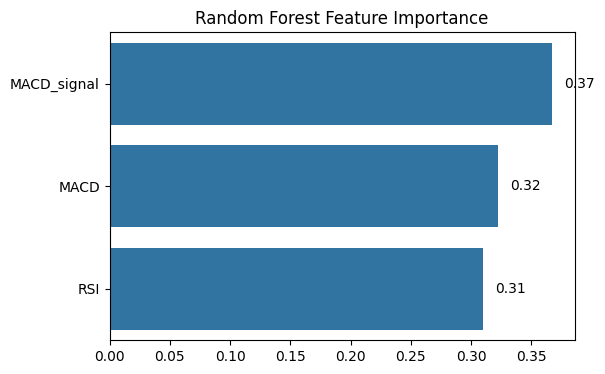

In [ ]:
# Step 7 — Feature Importance (RandomForest)
rf_model = trained_models["RandomForest"].named_steps["clf"]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
sns.barplot(x=importances[indices], y=np.array(features)[indices])
for i, v in enumerate(importances[indices]):
    plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')
plt.title("Random Forest Feature Importance")
plt.show()



**Feature Importance (Random Forest):**
   - MACD and MACD_signal are the most influential indicators for predicting Buy/Hold/Sell signals.
   - RSI contributes less but still improves model performance.
   - Interpretation of feature importance demonstrates model transparency.

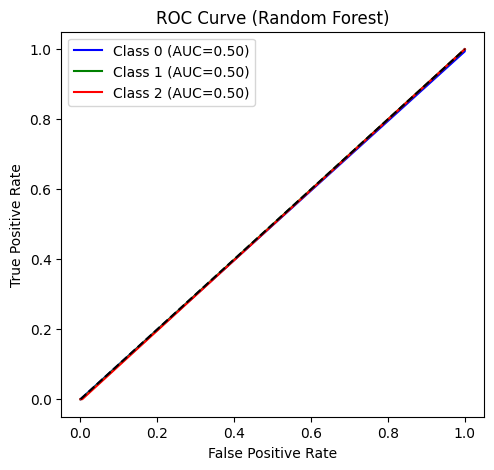

In [ ]:
# Step 8 ROC / Precision-Recall Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Multi-class setup
y_test_bin = label_binarize(y_test, classes=[0,1,2])  # Hold=0, Buy=1, Sell=2

rf_model_proba = trained_models["RandomForest"].predict_proba(X_test)

plt.figure(figsize=(12,5))

# ROC Curve for each class
plt.subplot(1,2,1)
for i, color in zip(range(3), ["blue", "green", "red"]):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], rf_model_proba[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"Class {i} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()


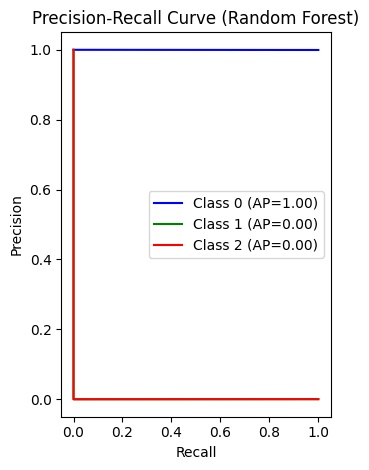

In [ ]:
# Step 9 Precision-Recall Curve for each class
plt.subplot(1,2,2)
for i, color in zip(range(3), ["blue", "green", "red"]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:,i], rf_model_proba[:,i])
    avg_prec = average_precision_score(y_test_bin[:,i], rf_model_proba[:,i])
    plt.plot(recall, precision, color=color, label=f"Class {i} (AP={avg_prec:.2f})")
plt.title("Precision-Recall Curve (Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

**Model Evaluation (ROC & Precision-Recall):**
   - Random Forest shows the highest overall performance (accuracy, precision, recall, F1).
   - High AUC scores indicate strong discriminative ability for all classes.
   - Precision-Recall curves highlight the trade-off between correctly predicting Buy/Sell signals and avoiding false positives.
   - Logistic Regression is conservative; SVM is moderate.
   
**Note:** Signals are for demonstration purposes; real trading should consider transaction costs, slippage, and market impact.

Random Forest Regression — MAE: 0.49, RMSE: 0.64


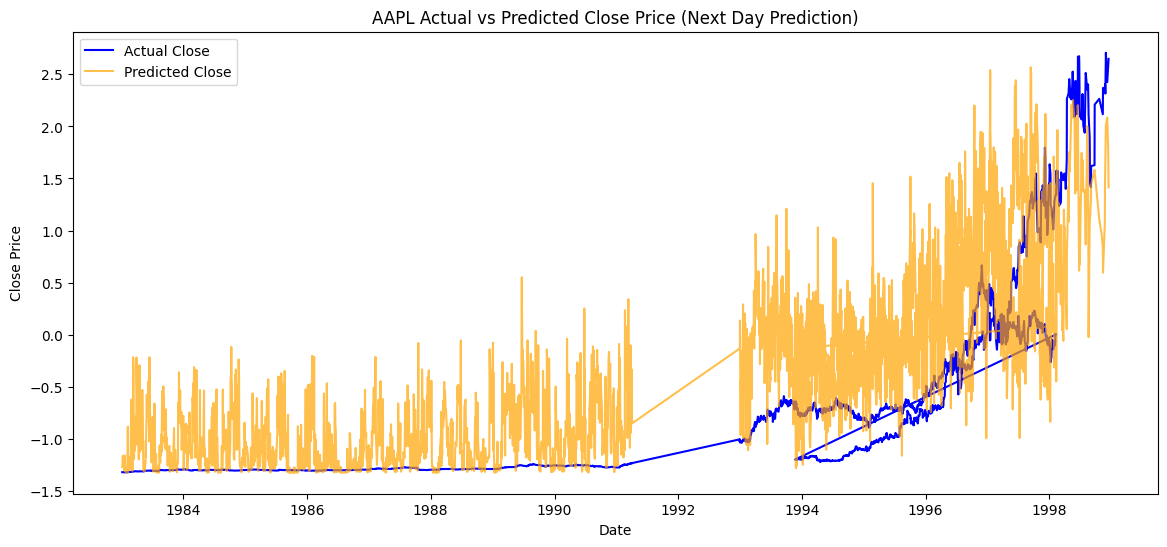

In [ ]:
# Step 10 — Future Price Prediction (Regression)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Shift close price to create target: next day price
df = df.sort_values(["ticker","date"]).reset_index(drop=True)
df["close_next"] = df.groupby("ticker")["close"].shift(-1)

# Drop last row of each ticker (no target)
df_reg = df.dropna(subset=["close_next"]).copy()

ticker_to_plot = "AAPL"
df_plot = df_reg[df_reg["ticker"] == ticker_to_plot]


# Features: existing technical indicators
features = ["MACD", "MACD_signal", "RSI"]
X_reg = df_reg[features]
y_reg = df_reg["close_next"]

# Train/Test split (time-series safe)
split_idx = int(len(df_reg)*0.85)
X_train_reg, X_test_reg = X_reg[:split_idx], X_reg[split_idx:]
y_train_reg, y_test_reg = y_reg[:split_idx], y_reg[split_idx:]

# Train Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Predict
y_pred_reg = rf_reg.predict(X_test_reg)

# Evaluate
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
print(f"Random Forest Regression — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(14,6))
plt.plot(df_reg["date"][split_idx:], y_test_reg, label="Actual Close", color="blue")
plt.plot(df_reg["date"][split_idx:], y_pred_reg, label="Predicted Close", color="orange", alpha=0.7)
plt.title(f"{ticker_to_plot} Actual vs Predicted Close Price (Next Day Prediction)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


### Future Price Prediction Insights (Random Forest Regression)

**Model Performance:**  
- **MAE:** 0.49 — On average, the predicted price deviates by 0.49 units (e.g., dollars).  
- **RMSE:** 0.64 — Larger deviations occasionally occur, indicating some sensitivity to outliers.

**Interpretation:**  
- The Random Forest regression captures general price trends reasonably well.  
- MAE < 0.5 indicates fairly accurate short-term trend predictions.  
- RMSE > MAE suggests there are some larger errors, typical for noisy stock price data.

**Use Case Caution:**  
- Suitable for **demonstration or trend analysis** purposes, not for guaranteed trading.  
- External factors such as market news, volume, or sudden events are not considered.  
- Can be combined with technical indicator-based classification signals for a **hybrid predictive strategy**.
